# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.model_selection import KFold
from scipy import stats
from mlxtend.evaluate import paired_ttest_kfold_cv
from sklearn.preprocessing import label_binarize
from sklearn import model_selection
from yellowbrick.classifier.rocauc import roc_auc
import time
import warnings

# Load Data

In [2]:
col_names = ['encounter_id','patient_nbr','race','gender','age','weight','admission_type_id','discharge_disposition_id','admission_source_id','time_in_hospital','payer_code','medical_specialty','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','diag_1','diag_2','diag_3','number_diagnoses','max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change','diabetesMed','readmitted']

diabetes = pd.read_csv("diabetic_data.csv", sep=",", header=0, names=col_names)

diabetes = pd.DataFrame(diabetes)

print('Number of samples:',len(diabetes))
diabetes.head()

Number of samples: 101765


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


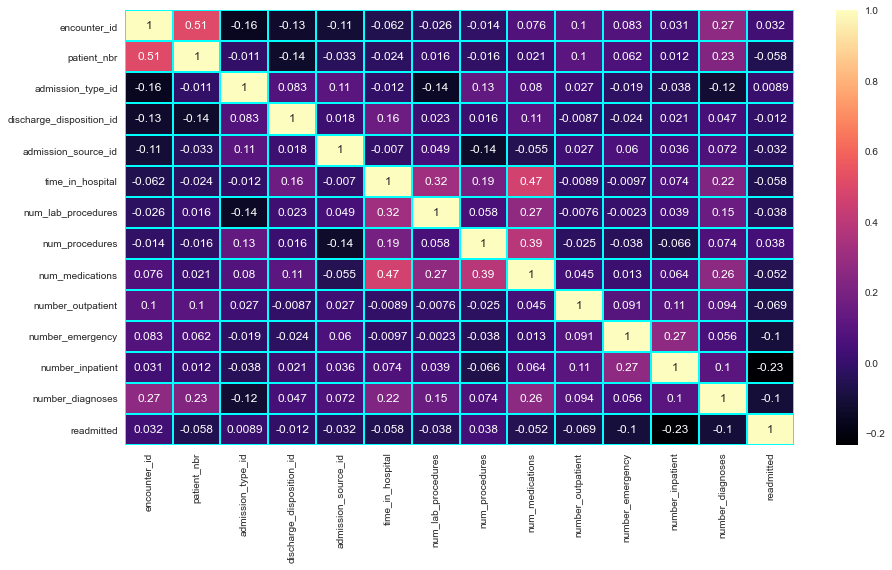

In [3]:
label_encoder = LabelEncoder()
diabetes['readmitted']= label_encoder.fit_transform(diabetes['readmitted']) 
plt.figure(figsize=(15,8))
sns.heatmap(diabetes.corr(),cmap='magma',linecolor='cyan',linewidths=1,annot=True)

# Data Cleaning and Data Preprocessing

In [4]:
# replace ? with nan
diabetes = diabetes.replace('?',np.nan)

diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101765 entries, 0 to 101764
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101765 non-null  int64 
 1   patient_nbr               101765 non-null  int64 
 2   race                      99492 non-null   object
 3   gender                    101765 non-null  object
 4   age                       101765 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101765 non-null  int64 
 7   discharge_disposition_id  101765 non-null  int64 
 8   admission_source_id       101765 non-null  int64 
 9   time_in_hospital          101765 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51816 non-null   object
 12  num_lab_procedures        101765 non-null  int64 
 13  num_procedures            101765 non-null  int64 
 14  num_

In [5]:
# Unique values for each column
for c in list(diabetes.columns):
    
    # get a list of unique values
    n = diabetes[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 101765 unique values
patient_nbr: 71517 unique values
race
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']
weight
[nan '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[1 2 3 6 4 5 8 7]
discharge_disposition_id
[ 1  3  6  2  5 11  7 25 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id
[ 7  2  4  1  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 3  2  1  4  5 13 12  9  7 10  6 11  8 14]
payer_code
[nan 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient

In [6]:
#Removing duplicates based on patient_nbr
diabetes = diabetes.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
diabetes.shape

(71517, 50)

In [7]:
#Glance on missing values
diabetes[col_names].isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         1948
gender                          0
age                             0
weight                      68664
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  31042
medical_specialty           34477
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         11
diag_2                        293
diag_3                       1224
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [7]:
# dropping columns with too many missing values
diabetes = diabetes.drop(['weight', 'payer_code'], axis = 1)

In [8]:
#Let's Investigate Age column 
diabetes.groupby('age').size()

age
[0-10)        153
[10-20)       535
[20-30)      1127
[30-40)      2699
[40-50)      6878
[50-60)     12466
[60-70)     15960
[70-80)     18210
[80-90)     11589
[90-100)     1900
dtype: int64

In [9]:
#Age replacing with interval mean values
age_id = {'[0-10)':5, 
          '[10-20)':15, 
          '[20-30)':25, 
          '[30-40)':35, 
          '[40-50)':45, 
          '[50-60)':55,
          '[60-70)':65, 
          '[70-80)':75, 
          '[80-90)':85, 
          '[90-100)':95}
diabetes['age'] = diabetes.age.replace(age_id)

In [10]:
#Let's investigate medical specialty
diabetes['medical_specialty'] = diabetes['medical_specialty'].fillna('UNK')
print('Number medical specialty:', diabetes.medical_specialty.nunique())
diabetes.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 71


medical_specialty
UNK                                 34477
InternalMedicine                    10919
Family/GeneralPractice               5118
Emergency/Trauma                     4465
Cardiology                           4266
                                    ...  
Resident                                1
Dermatology                             1
Speech                                  1
SportsMedicine                          1
Surgery-PlasticwithinHeadandNeck        1
Length: 71, dtype: int64

In [11]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# replace all specialties not in top 10 with 'Other' category
diabetes.loc[~diabetes.medical_specialty.isin(top_10),'medical_specialty'] = 'Other'

In [12]:
#Grouping medical_specialty
diabetes.groupby('medical_specialty').size()

medical_specialty
Cardiology                     4266
Emergency/Trauma               4465
Family/GeneralPractice         5118
InternalMedicine              10919
Nephrology                      828
Orthopedics                    1134
Orthopedics-Reconstructive     1043
Other                          6215
Radiologist                     831
Surgery-General                2221
UNK                           34477
dtype: int64

In [13]:
#Let's investigate admission_type_id
diabetes.admission_type_id.replace(
list(range(1,9)),['Emergency',
'Urgent',
'Elective',
'Newborn',
'Not Available',
'NULL',
'Trauma Center',
'Not Mapped'], inplace=True)
diabetes.admission_type_id.head()

0    Emergency
1    Emergency
2    Emergency
3    Emergency
4       Urgent
Name: admission_type_id, dtype: object

In [14]:
print('Number admission_type_id:', diabetes.admission_type_id.nunique())
diabetes.groupby('admission_type_id').size().sort_values(ascending = False)

Number admission_type_id: 8


admission_type_id
Emergency        36490
Elective         13917
Urgent           13028
NULL              4587
Not Available     3174
Not Mapped         291
Trauma Center       21
Newborn              9
dtype: int64

In [15]:
#Grouping admission_type_id
top_3 = ['Emergency','Elective','Urgent']
diabetes.loc[~diabetes.admission_type_id.isin(top_3),'admission_type_id'] = 'Other'
diabetes.groupby('admission_type_id').size()

admission_type_id
Elective     13917
Emergency    36490
Other         8082
Urgent       13028
dtype: int64

In [16]:
#Removing rows based on discharge_disposition_id
diabetes = diabetes.loc[~diabetes.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [17]:
#Let's investigate discharge_disposition_id
id_list = ['Discharged to home',
'Discharged/transferred to another short term hospital',
'Discharged/transferred to SNF',
'Discharged/transferred to ICF',
'Discharged/transferred to another type of inpatient care institution',
'Discharged/transferred to home with home health service',
'Left AMA',
'Discharged/transferred to home under care of Home IV provider',
'Admitted as an inpatient to this hospital',
'Neonate discharged to another hospital for neonatal aftercare',
'Expired',
'Still patient or expected to return for outpatient services',
'Hospice / home',
'Hospice / medical facility',
'Discharged/transferred within this institution to Medicare approved swing bed',
'Discharged/transferred/referred another institution for outpatient services',
'Discharged/transferred/referred to this institution for outpatient services',
'NULL',
'Expired at home. Medicaid only, hospice.',
'Expired in a medical facility. Medicaid only, hospice.',
'Expired, place unknown. Medicaid only, hospice.',
'Discharged/transferred to another rehab fac including rehab units of a hospital .',
'Discharged/transferred to a long term care hospital.',
'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
'Not Mapped',
'Unknown/Invalid',
'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
'Discharged/transferred to a federal health care facility.',
'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
'Discharged/transferred to a Critical Access Hospital (CAH).']

diabetes.discharge_disposition_id.replace(list(range(1,len(id_list)+1)),id_list, inplace=True)
diabetes.discharge_disposition_id.head()

0    Discharged to home
1    Discharged to home
2    Discharged to home
3    Discharged to home
4    Discharged to home
Name: discharge_disposition_id, dtype: object

In [18]:
print('Number discharge_disposition_id:', diabetes.discharge_disposition_id.nunique())
diabetes.groupby('discharge_disposition_id').size().sort_values(ascending = False)

Number discharge_disposition_id: 21


discharge_disposition_id
Discharged to home                                                                                         44317
Discharged/transferred to SNF                                                                               8784
Discharged/transferred to home with home health service                                                     8289
NULL                                                                                                        2474
Discharged/transferred to another short term hospital                                                       1539
Discharged/transferred to another rehab fac including rehab units of a hospital .                           1410
Discharged/transferred to another type of inpatient care institution                                         913
Not Mapped                                                                                                   777
Discharged/transferred to ICF                                          

In [19]:
#Grouping discharge_disposition_id
top_3 = ['Discharged to home','Discharged/transferred to SNF','Discharged/transferred to home with home health service']
diabetes.loc[~diabetes.discharge_disposition_id.isin(top_3),'discharge_disposition_id'] = 'Other'
diabetes.groupby('discharge_disposition_id').size()

discharge_disposition_id
Discharged to home                                         44317
Discharged/transferred to SNF                               8784
Discharged/transferred to home with home health service     8289
Other                                                       8582
dtype: int64

In [20]:
#Let's investigate diag_1
diabetes.replace(to_replace=r'^[EV][0-9]*', value='Other', regex=True, inplace = True)
diabetes_diag1 = diabetes['diag_1']
ICD_diag1 =[]
for i in diabetes_diag1:
    if ((i!='Other') and (i!='?')):
        if ((float(i) >=390 and float(i) <=459) or (float(i) == 785)):
            ICD_diag1.append('Circulatory')
        elif ((float(i) >=460 and float(i) <=519) or (float(i) == 786)):
            ICD_diag1.append('Respiratory')
        elif ((float(i) >=520 and float(i) <=579) or (float(i) == 787)):
            ICD_diag1.append('Digestive')
        elif (float(i) >=800 and float(i) <=999):
            ICD_diag1.append('Injury')
        elif (float(i) >=250 and float(i) < 251):
            ICD_diag1.append('Diabetes')
        elif (float(i) >=710 and float(i) <=739):
            ICD_diag1.append('Musculoskeletal')
        elif ((float(i) >=580 and float(i) <=629) or (float(i) == 788)):
            ICD_diag1.append('Genitourinary')
        elif ((float(i) >=140 and float(i) <=239)):
                ICD_diag1.append('Neoplasms')
        elif ((float(i) >=790 and float(i) <=799) or
              (float(i) >=240 and float(i) <=279 and float(i) !=250 ) or
              (float(i) == 780) or (float(i) == 781) or (float(i) == 784) or
              (float(i) >=680 and float(i) <=709) or
              (float(i) >=1 and float(i) <= 139) or
              (float(i) >=290 and float(i) <=319) or
              (float(i) >= 280 and float(i) <= 289) or
              (float(i) >= 320 and float(i) <= 359) or
              (float(i) >= 630 and float(i) <= 679) or
              (float(i) >= 360 and float(i) <= 389) or
              (float(i) >= 740 and float(i) <= 759) or
              (float(i) == 782)):
            ICD_diag1.append('Other')
        else:
            ICD_diag1.append('Other')
    else:
        ICD_diag1.append(i)
diabetes.drop(['diag_1'], axis=1,inplace=True)
diabetes['diag_1'] = ICD_diag1

In [21]:
#Let's investigate admission_source_id
id_list = ['Physician Referral',
'Clinic Referral',
'HMO Referral',
'Transfer from a hospital',
'Transfer from a Skilled Nursing Facility (SNF)',
'Transfer from another health care facility',
'Emergency Room',
'Court/Law Enforcement',
'Not Available',
'Transfer from critial access hospital',
'Normal Delivery',
'Premature Delivery',
'Sick Baby',
'Extramural Birth',
'Not Available',
'NULL',
'Transfer From Another Home Health Agency',
'Readmission to Same Home Health Agency',
'Not Mapped',
'Unknown/Invalid',
'Transfer from hospital inpt/same fac reslt in a sep claim',
'Born inside this hospital',
'Born outside this hospital',
'Transfer from Ambulatory Surgery Center',
'Transfer from Hospice']

diabetes.admission_source_id.replace(list(range(1,len(id_list)+1)),id_list, inplace=True)
diabetes.admission_source_id.head()

0     Emergency Room
1     Emergency Room
2     Emergency Room
3     Emergency Room
4    Clinic Referral
Name: admission_source_id, dtype: object

In [22]:
print('Number admission_source_id:', diabetes.admission_source_id.nunique())
diabetes.groupby('admission_source_id').size().sort_values(ascending = False)

Number admission_source_id: 17


admission_source_id
Emergency Room                                    37260
Physician Referral                                21745
Transfer From Another Home Health Agency           4820
Transfer from a hospital                           2530
Transfer from another health care facility         1785
Clinic Referral                                     908
Transfer from a Skilled Nursing Facility (SNF)      512
Unknown/Invalid                                     153
HMO Referral                                        136
Not Available                                        95
Court/Law Enforcement                                11
Transfer from critial access hospital                 7
Born inside this hospital                             4
Extramural Birth                                      2
Transfer from Hospice                                 2
Normal Delivery                                       1
Sick Baby                                             1
dtype: int64

In [23]:
#Grouping admission_source_id
top_3 = ['Emergency Room','Physician Referral','Transfer From Another Home Health Agency']
diabetes.loc[~diabetes.admission_source_id.isin(top_3),'admission_source_id'] = 'Other'
diabetes.groupby('admission_source_id').size()

admission_source_id
Emergency Room                              37260
Other                                        6147
Physician Referral                          21745
Transfer From Another Home Health Agency     4820
dtype: int64

In [24]:
# Data Insights of 23 medications
drugs =['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

medication = []
no_percent = []
for i in drugs:
    m=diabetes[i].value_counts(normalize=True) * 100
    for j,k in m.iteritems(): 
        if (j == 'No'):
            medication.append(i)
            no_percent.append(round(k,4))

data = {'Medication':medication,'No_Percent%':no_percent}
diabetes_no_count = pd.DataFrame(data)
sorted_no = diabetes_no_count.sort_values('No_Percent%',ascending=False)
print(sorted_no.to_string(index=False))

               Medication  No_Percent%
 glimepiride-pioglitazone     100.0000
              citoglipton     100.0000
                  examide     100.0000
   metformin-pioglitazone      99.9986
            acetohexamide      99.9986
  metformin-rosiglitazone      99.9971
             troglitazone      99.9957
      glipizide-metformin      99.9900
              tolbutamide      99.9757
                 miglitol      99.9714
               tolazamide      99.9571
           chlorpropamide      99.8985
                 acarbose      99.7142
              nateglinide      99.2983
      glyburide-metformin      99.2911
              repaglinide      98.6895
              glimepiride      94.7165
            rosiglitazone      93.3388
             pioglitazone      92.4784
                glyburide      88.8884
                glipizide      87.1277
                metformin      78.7015
                  insulin      48.9582


In [25]:
#Droping unwanted features
diabetes = diabetes.drop(['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'], axis = 1)
diabetes = diabetes.drop(['encounter_id','patient_nbr', 'diag_2','diag_3'], axis = 1)

# Split Dataset

In [26]:
#Split dataset in features and target variable
feature_cols = ['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','time_in_hospital','medical_specialty','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient', 'diag_1','number_diagnoses','max_glu_serum','insulin','A1Cresult','change','diabetesMed']
X = diabetes[feature_cols] # Features
y = diabetes.readmitted # Target variable
X.shape

(69972, 21)

In [27]:
#Making a copy of processesed Dataset
diabetes.to_csv(path_or_buf=r'C:\Users\ADMIN\Desktop\Diabetes_copy.csv', index=False)

# Encoding

In [28]:
#One-hot Encoding
X=pd.get_dummies(X,drop_first=True)
X.shape

(69972, 53)

# Sampling

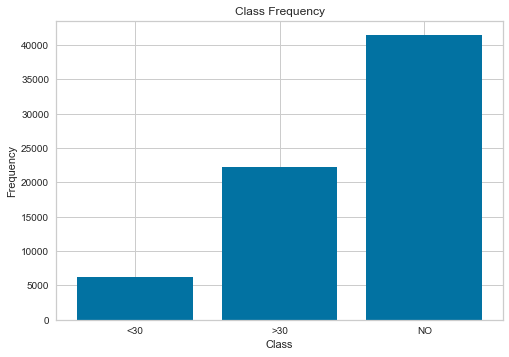

In [29]:
#Class Frequency
classes = diabetes.readmitted.values
unique, counts = np.unique(classes, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [30]:
#Balanced Sampling
print("Before BalancedSampling, counts of label '<30': {}".format(sum(y == "<30"))) 
print("Before BalancedSampling, counts of label '>30': {}".format(sum(y == ">30")))
print("Before BalancedSampling, counts of label 'NO': {} \n".format(sum(y == "NO"))) 

bs = SMOTETomek()
X_bs, y_bs = bs.fit_sample(X, y)
    
print("After BalancedSampling, counts of label '<30': {}".format(sum(y_bs == "<30"))) 
print("After BalancedSampling, counts of label '>30': {}".format(sum(y_bs == ">30")))
print("After BalancedSampling, counts of label 'NO': {}".format(sum(y_bs == "NO"))) 

Before BalancedSampling, counts of label '<30': 6277
Before BalancedSampling, counts of label '>30': 22222
Before BalancedSampling, counts of label 'NO': 41473 

After BalancedSampling, counts of label '<30': 41039
After BalancedSampling, counts of label '>30': 39522
After BalancedSampling, counts of label 'NO': 39490


In [31]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_bs, y_bs, test_size=0.30, random_state=1) 

In [32]:
#Initalizing Arrays
classifier_accuracy = []
classifier_precision = []
classifier_recall = []
classifier_f1score = []

# Decision Tree

Test Set Accuracy : 62.894269213682804 %


Classification Report : 

              precision    recall  f1-score   support

         <30       0.67      0.84      0.74      9819
         >30       0.41      0.61      0.49      8017
          NO       0.81      0.53      0.64     18180

    accuracy                           0.63     36016
   macro avg       0.63      0.66      0.62     36016
weighted avg       0.68      0.63      0.63     36016

Runtime:  6.019791126251221 seconds

Confusion Matrix:



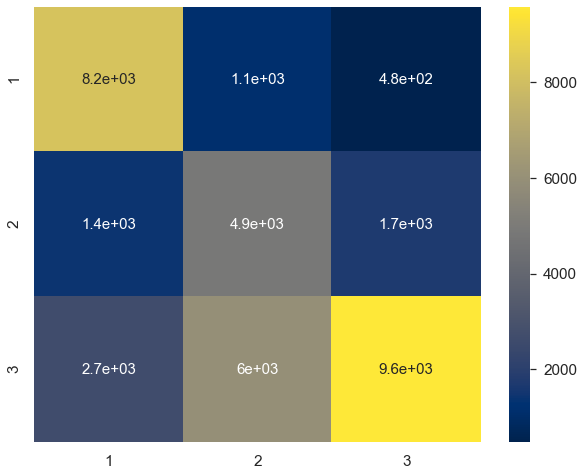

In [33]:
start = time.time()

# Creating the Decision Tree Classifier
model = OneVsRestClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=6)) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
dt_prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score( dt_prediction, y_test) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report( dt_prediction, y_test)}")

classifier_accuracy.append(accuracy_score(dt_prediction, y_test))   
classifier_precision.append(precision_score(dt_prediction, y_test, average='weighted'))
classifier_recall.append(recall_score(dt_prediction, y_test, average='weighted'))
classifier_f1score.append(f1_score(dt_prediction, y_test, average='weighted'))

cm = confusion_matrix(dt_prediction, y_test) 
cm_df = pd.DataFrame(cm, range(1,4),range(1,4))
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap='cividis',annot=True,annot_kws={"size": 15})

end = time.time()
print("Runtime: ",end - start, "seconds")
print("\nConfusion Matrix:\n")

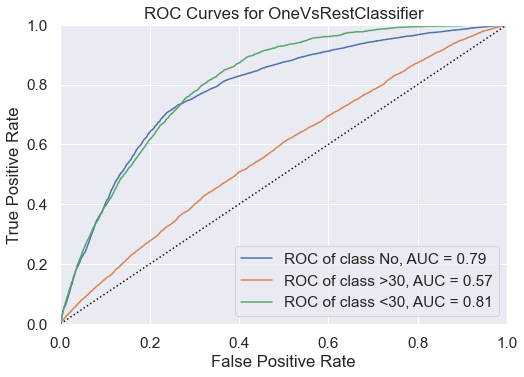

roc_auc <function roc_auc at 0x7fb8236e8a60>


In [36]:
#ROC Curve
warnings.filterwarnings('ignore')
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['No','>30','<30'],macro=False,micro=False)
print('roc_auc',roc_auc)

# Naive Bayesian - Bernoulli

Test Set Accuracy : 57.42170146601511 %


Classification Report : 

              precision    recall  f1-score   support

         <30       0.77      0.62      0.68     15338
         >30       0.20      0.42      0.27      5565
          NO       0.75      0.59      0.66     15113

    accuracy                           0.57     36016
   macro avg       0.57      0.54      0.54     36016
weighted avg       0.67      0.57      0.61     36016

Runtime:  2.541461944580078 seconds

Confusion Matrix:



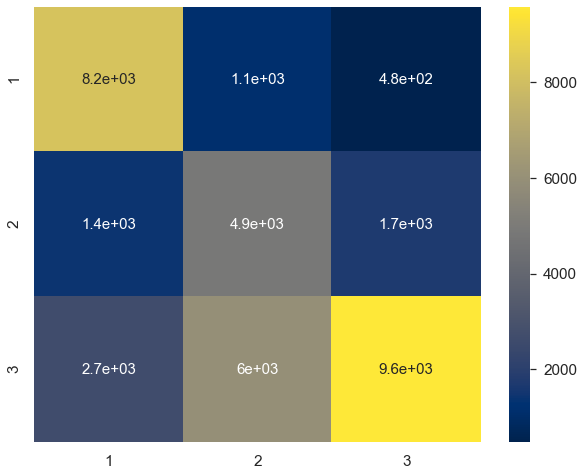

In [34]:
start = time.time()

# Creating the Bernoulli Classifier
model = OneVsRestClassifier(BernoulliNB()) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
bnb_prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score( bnb_prediction, y_test) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report( bnb_prediction, y_test)}")

classifier_accuracy.append(accuracy_score(bnb_prediction, y_test))   
classifier_precision.append(precision_score(bnb_prediction, y_test, average='weighted'))
classifier_recall.append(recall_score(bnb_prediction, y_test, average='weighted'))
classifier_f1score.append(f1_score(bnb_prediction, y_test, average='weighted'))

cm = confusion_matrix(dt_prediction, y_test) 
cm_df = pd.DataFrame(cm, range(1,4),range(1,4))
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap='cividis',annot=True,annot_kws={"size": 15})

end = time.time()
print("Runtime: ",end - start, "seconds")
print("\nConfusion Matrix:\n")

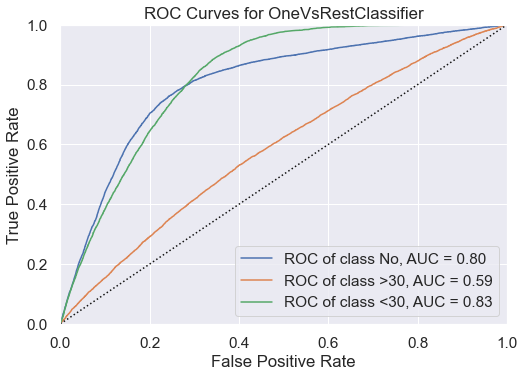

roc_auc <function roc_auc at 0x7f856d1d6430>


In [36]:
#ROC Curve
warnings.filterwarnings('ignore')
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['No','>30','<30'],macro=False,micro=False)
print('roc_auc',roc_auc)

# Distance Based Method - KNN Classifier

Test Set Accuracy : 64.11317192358952 %


Classification Report : 

              precision    recall  f1-score   support

         <30       0.94      0.64      0.76     18048
         >30       0.61      0.62      0.62     11786
          NO       0.35      0.67      0.46      6182

    accuracy                           0.64     36016
   macro avg       0.64      0.65      0.62     36016
weighted avg       0.73      0.64      0.66     36016

Runtime:  32.67259693145752 seconds

Confusion Matrix:



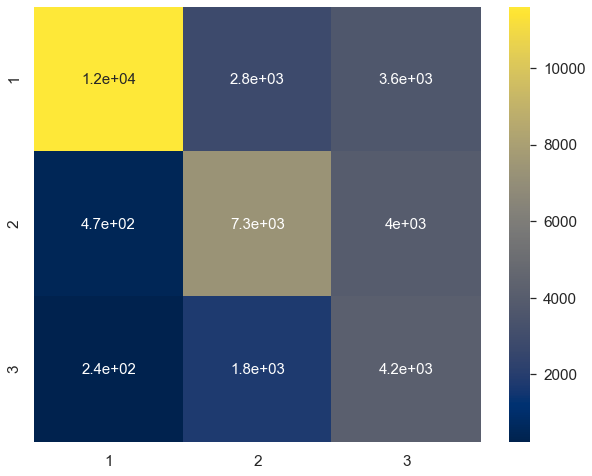

In [37]:
start = time.time()

# Creating the KNN Classifier
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=7)) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
knn_prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score( knn_prediction, y_test) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report( knn_prediction, y_test)}")

classifier_accuracy.append(accuracy_score(knn_prediction, y_test))   
classifier_precision.append(precision_score(knn_prediction, y_test, average='weighted'))
classifier_recall.append(recall_score(knn_prediction, y_test, average='weighted'))
classifier_f1score.append(f1_score(knn_prediction, y_test, average='weighted'))

cm = confusion_matrix(knn_prediction, y_test) 
cm_df = pd.DataFrame(cm, range(1,4),range(1,4))
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap='cividis',annot=True,annot_kws={"size": 15})

end = time.time()
print("Runtime: ",end - start, "seconds")
print("\nConfusion Matrix:\n")

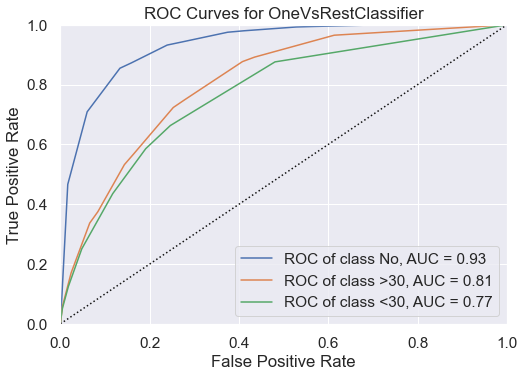

roc_auc <function roc_auc at 0x7f856d1d6430>


In [38]:
#ROC Curve
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['No','>30','<30'],macro=False,micro=False)
print('roc_auc',roc_auc)

# Linear Model - SVM

Test Set Accuracy : 56.48322967569969 %


Classification Report : 

              precision    recall  f1-score   support

         <30       0.81      0.57      0.67     17686
         >30       0.01      0.51      0.02       195
          NO       0.87      0.56      0.68     18135

    accuracy                           0.56     36016
   macro avg       0.56      0.55      0.46     36016
weighted avg       0.84      0.56      0.67     36016

Runtime:  2503.8849608898163 seconds

Confusion Matrix:



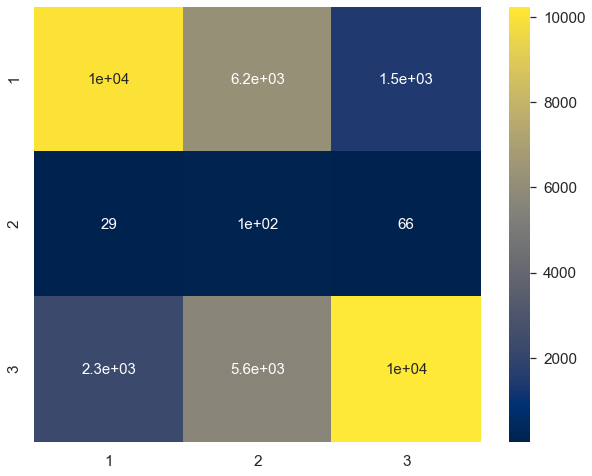

In [39]:
start = time.time()

# Creating the SVM model 
model = OneVsRestClassifier(SVC(kernel="linear")) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
svm_prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score( svm_prediction, y_test) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report( svm_prediction, y_test)}") 

classifier_accuracy.append(accuracy_score(svm_prediction, y_test))   
classifier_precision.append(precision_score(svm_prediction, y_test, average='weighted'))
classifier_recall.append(recall_score(svm_prediction, y_test, average='weighted'))
classifier_f1score.append(f1_score(svm_prediction, y_test, average='weighted'))

cm = confusion_matrix(svm_prediction, y_test) 
cm_df = pd.DataFrame(cm, range(1,4),range(1,4))
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap='cividis',annot=True,annot_kws={"size": 15})

end = time.time()
print("Runtime: ",end - start, "seconds")
print("\nConfusion Matrix:\n")

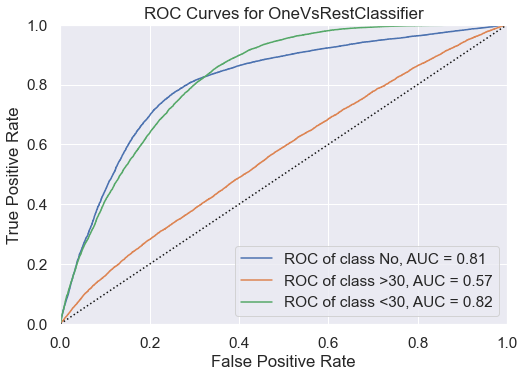

roc_auc <function roc_auc at 0x7f856d1d6430>


In [40]:
#ROC Curve
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['No','>30','<30'],macro=False,micro=False)
print('roc_auc',roc_auc)

# Random Forest Classifier

Test Set Accuracy : 70.87405597512216 %


Classification Report : 

              precision    recall  f1-score   support

         <30       0.83      0.81      0.82     12646
         >30       0.47      0.70      0.56      8027
          NO       0.83      0.63      0.72     15343

    accuracy                           0.71     36016
   macro avg       0.71      0.71      0.70     36016
weighted avg       0.75      0.71      0.72     36016

Runtime:  49.10760235786438 seconds

Confusion Matrix:



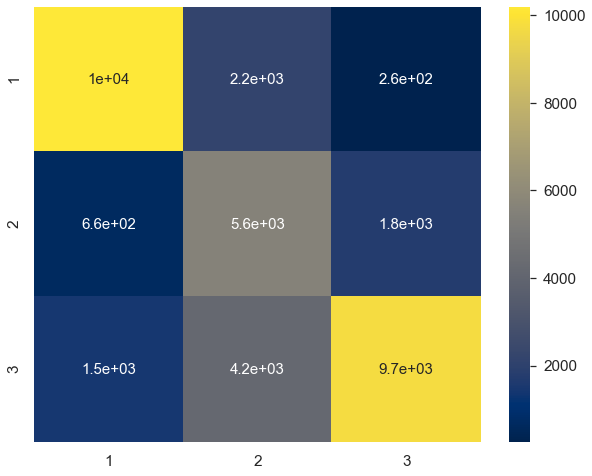

In [41]:
start = time.time()

# Creating the Random Forest Classifier
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100)) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
rf_prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score( rf_prediction, y_test) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report( rf_prediction, y_test)}")

classifier_accuracy.append(accuracy_score(rf_prediction, y_test))   
classifier_precision.append(precision_score(rf_prediction, y_test, average='weighted'))
classifier_recall.append(recall_score(rf_prediction, y_test, average='weighted'))
classifier_f1score.append(f1_score(rf_prediction, y_test, average='weighted'))

cm = confusion_matrix(rf_prediction, y_test) 
cm_df = pd.DataFrame(cm, range(1,4),range(1,4))
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap='cividis',annot=True,annot_kws={"size": 15})

end = time.time()
print("Runtime: ",end - start, "seconds")
print("\nConfusion Matrix:\n")

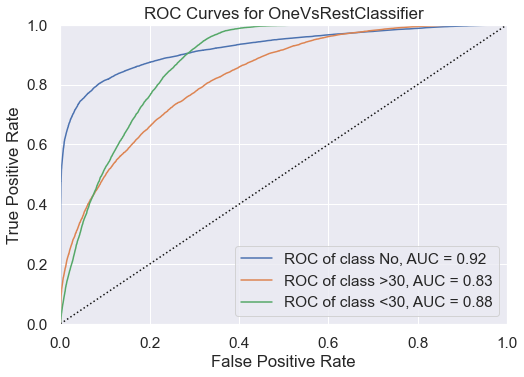

roc_auc <function roc_auc at 0x7f856d1d6430>


In [42]:
#ROC Curve
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['No','>30','<30'],macro=False,micro=False)
print('roc_auc',roc_auc)

# Extra Tree Classifier

Test Set Accuracy : 68.36961350510884 %


Classification Report : 

              precision    recall  f1-score   support

         <30       0.80      0.79      0.79     12382
         >30       0.47      0.63      0.53      8865
          NO       0.79      0.63      0.70     14769

    accuracy                           0.68     36016
   macro avg       0.68      0.68      0.68     36016
weighted avg       0.71      0.68      0.69     36016

Runtime:  58.49414610862732 seconds

Confusion Matrix:



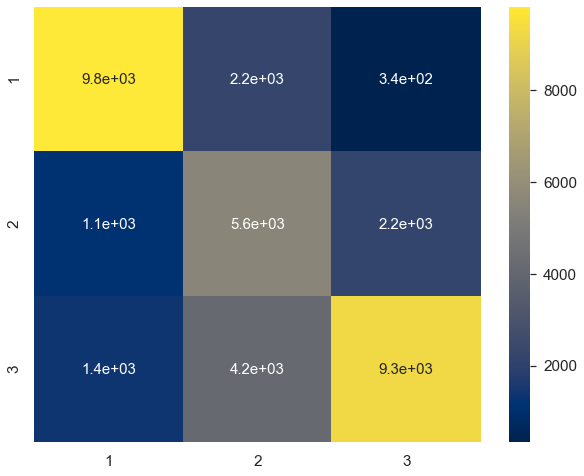

In [43]:
start = time.time()

# Creating the Extra Tree Classifier
model = OneVsRestClassifier(ExtraTreesClassifier()) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
et_prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score(et_prediction, y_test) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report( et_prediction, y_test)}")

classifier_accuracy.append(accuracy_score(et_prediction, y_test))   
classifier_precision.append(precision_score(et_prediction, y_test, average='weighted'))
classifier_recall.append(recall_score(et_prediction, y_test, average='weighted'))
classifier_f1score.append(f1_score(et_prediction, y_test, average='weighted'))

cm = confusion_matrix(et_prediction, y_test) 
cm_df = pd.DataFrame(cm, range(1,4),range(1,4))
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap='cividis',annot=True,annot_kws={"size": 15})

end = time.time()
print("Runtime: ",end - start, "seconds")
print("\nConfusion Matrix:\n")

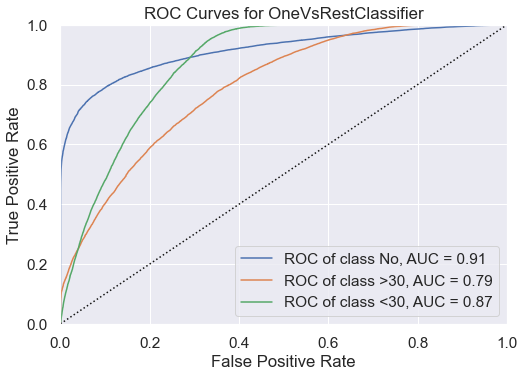

roc_auc <function roc_auc at 0x7f856d1d6430>


In [44]:
#ROC Curve
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['No','>30','<30'],macro=False,micro=False)
print('roc_auc',roc_auc)

# Ensemble - Bagging Classifier

Test Set Accuracy : 71.76810306530432 %


Classification Report : 

              precision    recall  f1-score   support

         <30       0.84      0.81      0.82     12660
         >30       0.52      0.70      0.60      8873
          NO       0.80      0.65      0.71     14483

    accuracy                           0.72     36016
   macro avg       0.72      0.72      0.71     36016
weighted avg       0.74      0.72      0.72     36016

Runtime:  104.27998399734497 seconds

Confusion Matrix:



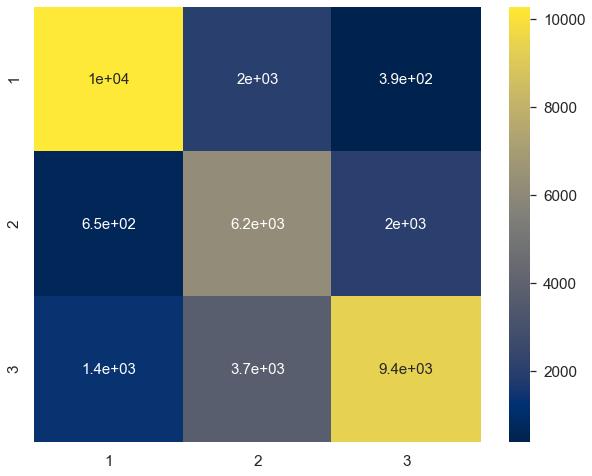

In [45]:
start = time.time()

# Creating the Bagging Classifier
model = OneVsRestClassifier(BaggingClassifier(DecisionTreeClassifier(),n_estimators = 50)) 
   
# Fitting the model with training data 
model.fit(X_train, y_train) 
   
# Making a prediction on the test set 
bg_prediction = model.predict(X_test) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score(bg_prediction, y_test) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report( bg_prediction, y_test)}")

classifier_accuracy.append(accuracy_score(bg_prediction, y_test))   
classifier_precision.append(precision_score(bg_prediction, y_test, average='weighted'))
classifier_recall.append(recall_score(bg_prediction, y_test, average='weighted'))
classifier_f1score.append(f1_score(bg_prediction, y_test, average='weighted'))

cm = confusion_matrix(bg_prediction, y_test) 
cm_df = pd.DataFrame(cm, range(1,4),range(1,4))
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df,cmap='cividis',annot=True,annot_kws={"size": 15})

end = time.time()
print("Runtime: ",end - start, "seconds")
print("\nConfusion Matrix:\n")

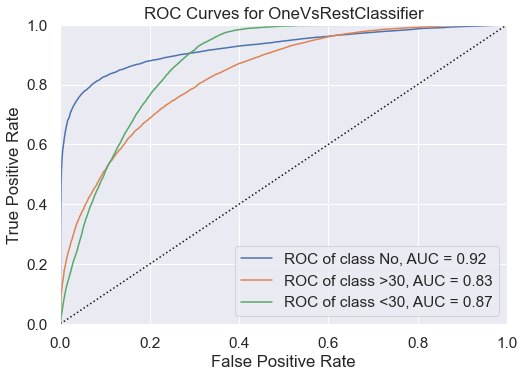

roc_auc <function roc_auc at 0x7f856d1d6430>


In [46]:
#ROC Curve
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['No','>30','<30'],macro=False,micro=False)
print('roc_auc',roc_auc)

In [47]:
#Accuracy Table
M = ["DecisionTreeClassifier" , "BernoulliNB" ,"KNNClassifier", "LinearSVC", "RandomForestClassifier" , "ExtraTreeClassifier", "BaggingClassifier"]
Table = { "Algorithm" : M, "Accuracy" : classifier_accuracy, "Precision" : classifier_precision, "Recall" : classifier_recall, "F1 score" : classifier_f1score}
Acc_table = pd.DataFrame(Table)
Acc_table

,Algorithm,Accuracy,Precision,Recall,F1 score
0,DecisionTreeClassifier,0.628943,0.683401,0.628943,0.633684
1,BernoulliNB,0.574217,0.674026,0.574217,0.609818
2,KNNClassifier,0.641132,0.733875,0.641132,0.664724
3,LinearSVC,0.564832,0.837585,0.564832,0.672579
4,RandomForestClassifier,0.708741,0.747829,0.708741,0.717795
5,ExtraTreeClassifier,0.683696,0.711178,0.683696,0.690766
6,BaggingClassifier,0.717681,0.741656,0.717681,0.723221


In [48]:
#Ten Fold Cross Validation - Random Forest 
rf_tfcv = model_selection.KFold(n_splits=10, random_state=None)
model_rf_tfcv = RandomForestClassifier(n_estimators=7)
result_rf_tfcv = model_selection.cross_val_score(model_rf_tfcv, X, y, cv=rf_tfcv)
print(result_rf_tfcv)
print("\nAccuracy:",  (result_rf_tfcv.mean() *100.0)) 

[0.52900829 0.55087168 0.58610833 0.58067743 0.49306846 0.50864656
 0.52922681 0.53037016 0.55495212 0.55638131]

Accuracy: 54.1931115049797


In [49]:
#Ten Fold Cross Validation - Bagging Classifier 
bg_tfcv = model_selection.KFold(n_splits=10, random_state=None)
model_bg_tfcv = BaggingClassifier(n_estimators=7)
result_bg_tfcv = model_selection.cross_val_score(model_bg_tfcv, X, y, cv=bg_tfcv)
print(result_bg_tfcv)
print("\nAccuracy:",  (result_bg_tfcv.mean() *100.0)) 

[0.51671906 0.54315519 0.57567529 0.55881092 0.48306417 0.50578819
 0.51679291 0.51850793 0.54323281 0.55123624]

Accuracy: 53.12982724846393


In [50]:
print("\nPaired-t-test:")
print("\nRandomForest-BaggingClassifier:", stats.ttest_rel(result_rf_tfcv, result_bg_tfcv))


Paired-t-test:

RandomForest-BaggingClassifier: Ttest_relResult(statistic=6.588961254883599, pvalue=0.00010054530079059334)


The Random Forest and Bagging Classifier are Statistically Significant because the pair has p value below 0.05. 